<style>
th{
  background-color: rgb(200,200,200);
  color: black;
  font-weight: bold;
  border: 1px solid white; 
  border-collapse: collapse;
}
td {
  background-color: rgb(220,220,220);
  color: black;
  font-weight: normal;
  border: 1px solid white;
  border-collapse: collapse;
}

table {
  width: 100%;
  table-layout: fixed;
}

table.ml-canvas td {
    vertical-align: top;
    border: 2px solid black;
}
</style>

# Yelp Dataset Analysis

In this notebook, we want to play around with the yelp dataset. Our goal is to come up with a valid business application for data science based on the Yelp dataset as if we were working for Yelp. Additionally, we want to showcase our idea and prove that it works.

## Table of contents

1. [Use Case Ideation and Selection](#introduction)
2. [Detailed Definition of Use Case Idea](#definition)

    2.1 [Data Product Canvas](#data_product_canvas)
    
    2.2 [Machine Learning Canvas](#machine_learning_canvas)
3. [Implementation](#implementation)

    3.1 [Implementation Plan](#implementation_plan)
    
    3.2 [Semantic Analysis with VADER](#vader)
    
    3.3 [Topic Modelling with LDA](#lda)
    
    3.4 [Creating Topic Scores](#combine)
4. [Evaluation](#evaluation)

# <a id='introduction'>1. Use Case Ideation and Selection</a>

Yelp is a social media and rating platform provider, that allows users to rate and search for businesses all around the world. That way users can find highly valued restaurants and the like more easily. Addtionally, users get personalized recommendations based on their searches.

Yelp earns most of its revenue via ads. Businesses are able to purchase higher ranked ads to appear first for certain searches on yelp (similarly to Google ads). Yelp uses machine learning to predict the click-through-rate (CTR) and success rate of each ad in order to maximize the return on investment for businesses purchasing ads and thereby reducing cost per click and marketing costs in general.

Obviously, Yelp is totally depending on its active community. To keep the community alive, the Yelp Elite Squad targets very active users, to motivate them to keep posting reviews. Members of the Yelp Elite Squad receive virtual badges and may attend exclusive behind the scenes events of local businesses. Often times these include the business owners who share their unique story.

As mentioned during the introduction, we plan on coming up with use cases from the perspective of Yelp. The main customers of Yelp are businesses that pay for ads on the platform. However, that's only possible, because there is an active community behind it and people use Yelp a whole lot. Thus, we will focus with our idea finding on adding value for the businesses and/or the users.

## List of Ideas 

__Elite user churn prediction__<br/>Elite users are the ones that have a big influence on the overall reviews and their helpfulness. Thus, Yelp is interested in keeping these kind of members active. One idea would be to analyze what makes elite users churn the program and if we are able to predict churn. If so, Yelp might reactivate the users with an incentive (i.e. some elite event or similar).
<div class="alert alert-info">After a first view of the data, we saw, that users stayed elite, even though they have not added any reviews in the past year. As I did not expect to see this behavior, I refrain from this use case.</div>

__Business rating prediction based on photos and meta-data__<br/>If new businesses open up, it would be very helpful to know what kind of interior and exterior design they would have to choose that helps increase their rating. If we are able to find drivers of rating in pictures and metadata, we might offer helpful insights to new businesses, how to optimize their rating by design choices.
<div class="alert alert-info">I don't have a GPU available for training an CNN approach, so I will not continue with this idea.</div>

__Friend Recommender to community members based on writing style and similar interests__<br/>The older we get, the harder it gets to make new friends. As friends tend to like similar things and have similar intellects and phrases they use, we might be able to help our fellow users in connecting with like-minded peers in their close neighborhood. <br />If we succeed, Yelp users have more incentives to use the platform and writing reviews actively, as it will lead to more fitting friend recommendations. Plus, it would incentivize users to write more natural reviews, making fake reviews stand out a bit more.
<div class="alert alert-info">This would be a fun project. However, after checking the initial data, we found, that some people have 200.000 friends. Thus, this project might be a little over the top for this short amount of time. One could use approaches as outlined <a href="https://github.com/vineetamonkar/Friend-Recommendation-System-using-Python/blob/master/Friend_recommendation_system%20-%20final%20report.pdf">here</a>.</div>

__Next best business to visit__<br/> Recommend businesses to a user, which he/she might like based on his/her ratings and reviews and those of similar users.
<div class="alert alert-info">This is an obvious one and has been solved with many different approaches on the internet.</div>

__Predict business category labels__<br/>This was the original Yelp dataset challenge. 
<div class="alert alert-info">I will not go into detail here, as there are many solutions available on the internet for this problem.</div>

__More detailed ratings__<br/> Right now, there is one single dimension that is rated on yelp. However, users rate businesses based on different dimension, e.g. service, price, quality of product/service, ambience, etc. There are multiple benefits, if we can detail ratings to specific categories and allow filtering these over time windows:
1. The users can select businesses based on what's important for them
2. Businesses can view their ratings over the past X month and identify issues that caused drops in ratings.
3. Users can also view the most recent business ratings and see if anything changed (e.g. became more pricey)
    
We will go with this use case idea. It has been done in the past, however, it leaves room for improvement and brings benefits to the users and the businesses.

# <a id='details'>2. Detailed Definition of Use Case Idea</a>

In this section, we will detail our idea using the data product canvas and the machine learning canvas. Whilst there are overlaps, the data product canvas outlines the idea more from a business perspective and the machine learning canvas from a data science perspective.

## __<a id='data_product_canvas'>2.1 Data Product Canvas</a>__

<table>
    <tr>
      <th><b>BUSINESS CONTEXT</b></th>
      <th><b>BUSINESS GOALS</b></th>
      <th><b>DATA PRODUCT</b></th>
      <th><b>PROCESSING</b></th>
      <th><b>DATA</b></th>
    </tr>
    <tr>
      <td>
        Yelp elite squad is a program for members that are especially active. They are motivated to stay active and elite members by granting virtual badges and 
        being able to take part in special events with local businesses. However, the average elite member stays elite for `TODO` amount of days. Especially in areas where there are not many elite members it would be beneficial too keep these special members active to increase the value of the platform to businesses in these areas.
      </td>
      <td>
        The goal would be to detect 80% of churns accurately whilst having a maximum of 5% false positives (falsely identified as churn members). The prediction needs to be done at least 6 month in advance (so on 30th of June) to have enough time to react to churners until the end of the year.
      </td>
      <td>
        <ul>
          <li>Binary classification into churn and no churn based on the history of reviews a user made in the previous year.</li>
          <li>We provide the classification results as a batch list to the user satisfaction team.</li>
        </ul>
      </td>
      <td>
        Processing happens once a year. Potentially more often, if we can predict further into the future.
      </td>
      <td>
        <ul>
          <li>User data</li>
          <li>reviews</li>
          <li>(+ maybe pictures for V2.0)</li>
        </ul>
      </td>
    </tr>
    <tr>
      <th><b>USER GROUPS</b></th>
      <th><b>USER PAINT POINTS</b></th>
      <th><b>INTERFACE</b></th>
      <th><b>ETHICS</b></th>
      <th><b>LEGAL</b></th>
    </tr>
    <tr>
      <td>User Satisfaction Team Members</td>
      <td>
        <ul>
          <li>They don't know which users might become inactive</li>
          <li>They want to spend the money for incentives the most efficient way</li>
          <li>They are responsible for keeping elite members active, but lack the information mentioned above</li>
        </ul>
      </td>
      <td>
        Batch File once a year or more often if required. (maybe monthly?)
      </td>
      <td>
        No ethical issues involved
      </td>
      <td>
        No legal issues involved, as users agreed to DSE.
        We need to exclude users that have asked for deletion of data or did not accept the DSE. In that case, they are not part of this dataset, so we can continue on normally.
      </td>
    </tr>
</table>

## __<a id='machine_learning_canvas'>2.2 Machine Learning Canvas</a>__
<table class="ml-canvas">
  <tr>
    <td><b>PREDICTION TASK</b>
      <br/>Binary Classification to predict if an existing elite customer churns (i.e. becomes inactive / non-elite) or stays elite member.
      Is partially based on time-series data, which could either be flattened or fed into a respective time-series model (i.e. RNN) and flattened afterwards.
    </td>
    <td><b>DECISIONS</b>
      <br/>All elite users will be filtered to those that are likely to churn.
    </td>
    <td rowspan="2"><b>VALUE PROPOSITION</b>
      <br/>Those users that are likely to churn will be contacted by the user satisfication team with e-mail offers and the like. This requires an interface to the e-mail sending system to send the mails without user interference.
    </td>
    <td><b>DATA COLLECTION</b>
      <br/>The ML model can be based on the existing review data and the data of the users. As we already collect this data, a constant retraining is possible.
    </td>
    <td><b>DATA SOURCES</b>
      <br/>Reviews and User data tables.
    </td>
  </tr>
  <tr>
    <td rowspan="2"><b>IMPACT SIMULATION</b>
      <br/>The costs of incorrect decisions are neglectable. However, it is more important to identify all churners than it is to avoid false positives.
    </td>
    <td><b>MAKING PREDICTIONS</b>
      <br/>We make batch predictions and have virtually no time limit to do so. All necessary features can therefore be calculated on the fly from the base data tables.
    </td>
    <td><b>BUILDING MODELS</b>
      <br/>One model is required. As we only know until next year if our predictions are correct, retraining once a year should be sufficient. There is virtually no time-limit for this task.
    </td>
    <td rowspan="2"><b>FEATURES</b>
      <ul>
        <li>history of user reviews</li>
        <li>length of individual reviews</li>
        <li>received feedback for reviews</li>  
        <li>pictures uploaded by user</li>
        <li>frequency of reviews per month</li>
      </ul>
    </td>
  </tr>
  <tr>
    <td colspan="3"><b>MONITORING</b>
      <br/>We should measure the amount of churns we prevented by gathering direct user feedback on whether they thought about quitting in the past. 
    </td>
  </tr>
</table>

In [1]:
# for data processing
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas() 
import itertools

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

# for nlp
import gensim
from gensim.utils import simple_preprocess
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
import nltk
from nltk import FreqDist
import gensim.corpora as corpora
from gensim.models import CoherenceModel

import joblib

# download required sources
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-d

True

Only take restaurants into account. We want to find out, what it is what makes restaurants go up or down in rating significantly.

In [2]:
restaurants = pd.read_csv('../data/vancouver_restaurant.csv')

# EDA on restaurants in Vancouver
A bit of explorative data analysis, to get used to the data and see if our business case is actually valid.

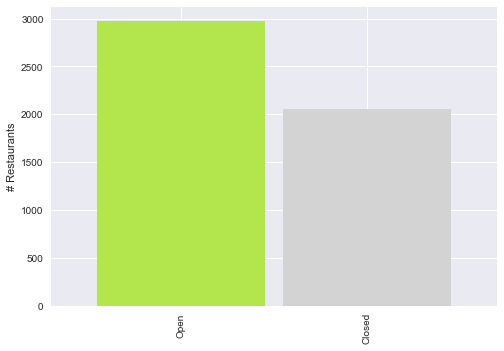

In [3]:
plt.style.use('seaborn')

restaurants['is_open_cat'] = restaurants.is_open.apply(lambda x : 'Open' if x == 1 else 'Closed')

ax = plt.subplot()
restaurants.is_open_cat.value_counts().plot(ax=ax, kind='bar', width=0.9, color=[(0.7,0.9,0.3), 'lightgrey'])
ax.set_ylabel('# Restaurants')
plt.show()

There are a lot of closed restaurants. Let's compare the average star rating.

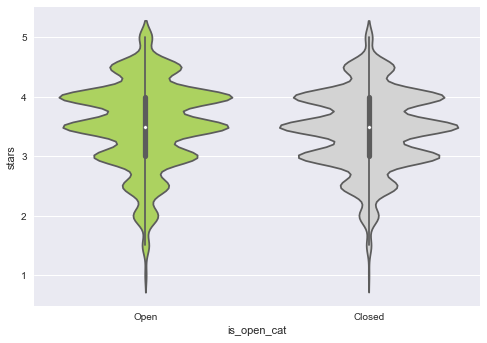

In [4]:
ax = plt.subplot()

my_palette = {"Open": (0.7,0.9,0.3), "Closed": "lightgrey"}

sns.violinplot(x='is_open_cat',y='stars', data=restaurants, ax = ax, palette = my_palette)
plt.show()

The differences between closed and open restaurants is only marginal. I still do expect some differences in the text ratings, though. 

Most users vote around 4 stars. 1 star is extremely seldom (the Canadians are truely polite people 😊). 

Let's now take a look at the restaurants in general. Plot the top 10most occurring categories.

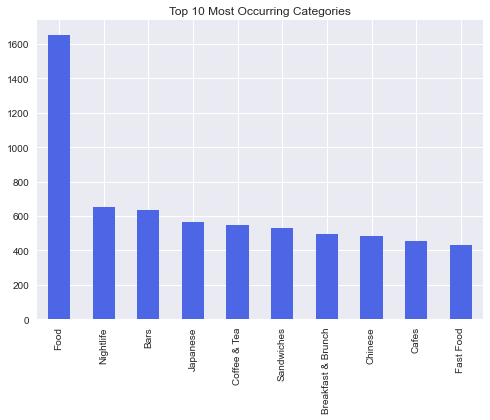

In [5]:
ax = plt.subplot()
categories = restaurants.categories.str.split(', ', expand=True)
categories['business_id'] = restaurants['business_id']
categories.melt('business_id', value_name='category').dropna().sort_values('business_id').query('category != "Restaurants"').category.value_counts()[:10].plot(kind='bar', ax=ax, color=(0.3,0.4,0.9))
ax.set_title('Top 10 Most Occurring Categories')
plt.show()

## Read the reviews
Now read the reviews, to see if they vary over time.

In [6]:
reviews = pd.read_csv('../data/vancouver_reviews.csv')
reviews.shape

(373148, 9)

In [7]:
reviews['yearmon'] = reviews['date'].str[0:7]
reviews['year'] = reviews['date'].str[0:4]
reviews['quarter'] = pd.to_datetime(reviews['date'], format='%Y-%m-%d').dt.quarter

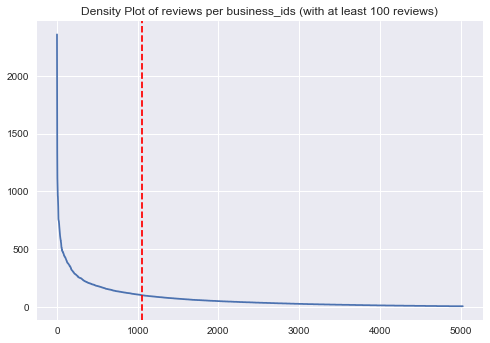

In [8]:
ax = plt.subplot()
line_at = 100

ax.set_title(f'Density Plot of reviews per business_ids (with at least {line_at} reviews)')
business_ids_with_sufficient_reviews = reviews.business_id.value_counts()[reviews.business_id.value_counts() > line_at].index.values
reviews.business_id.value_counts().reset_index()['business_id'].plot(ax=ax)
number_of_businesses_with_sufficient_reviews = sum(reviews.business_id.value_counts() > line_at)
ax.axvline(number_of_businesses_with_sufficient_reviews, linestyle='--', color = 'red')
plt.show()

We have roughly 1000 companies, that have more than 100 reviews. For these, we should be able to get a nice development of star ratings.

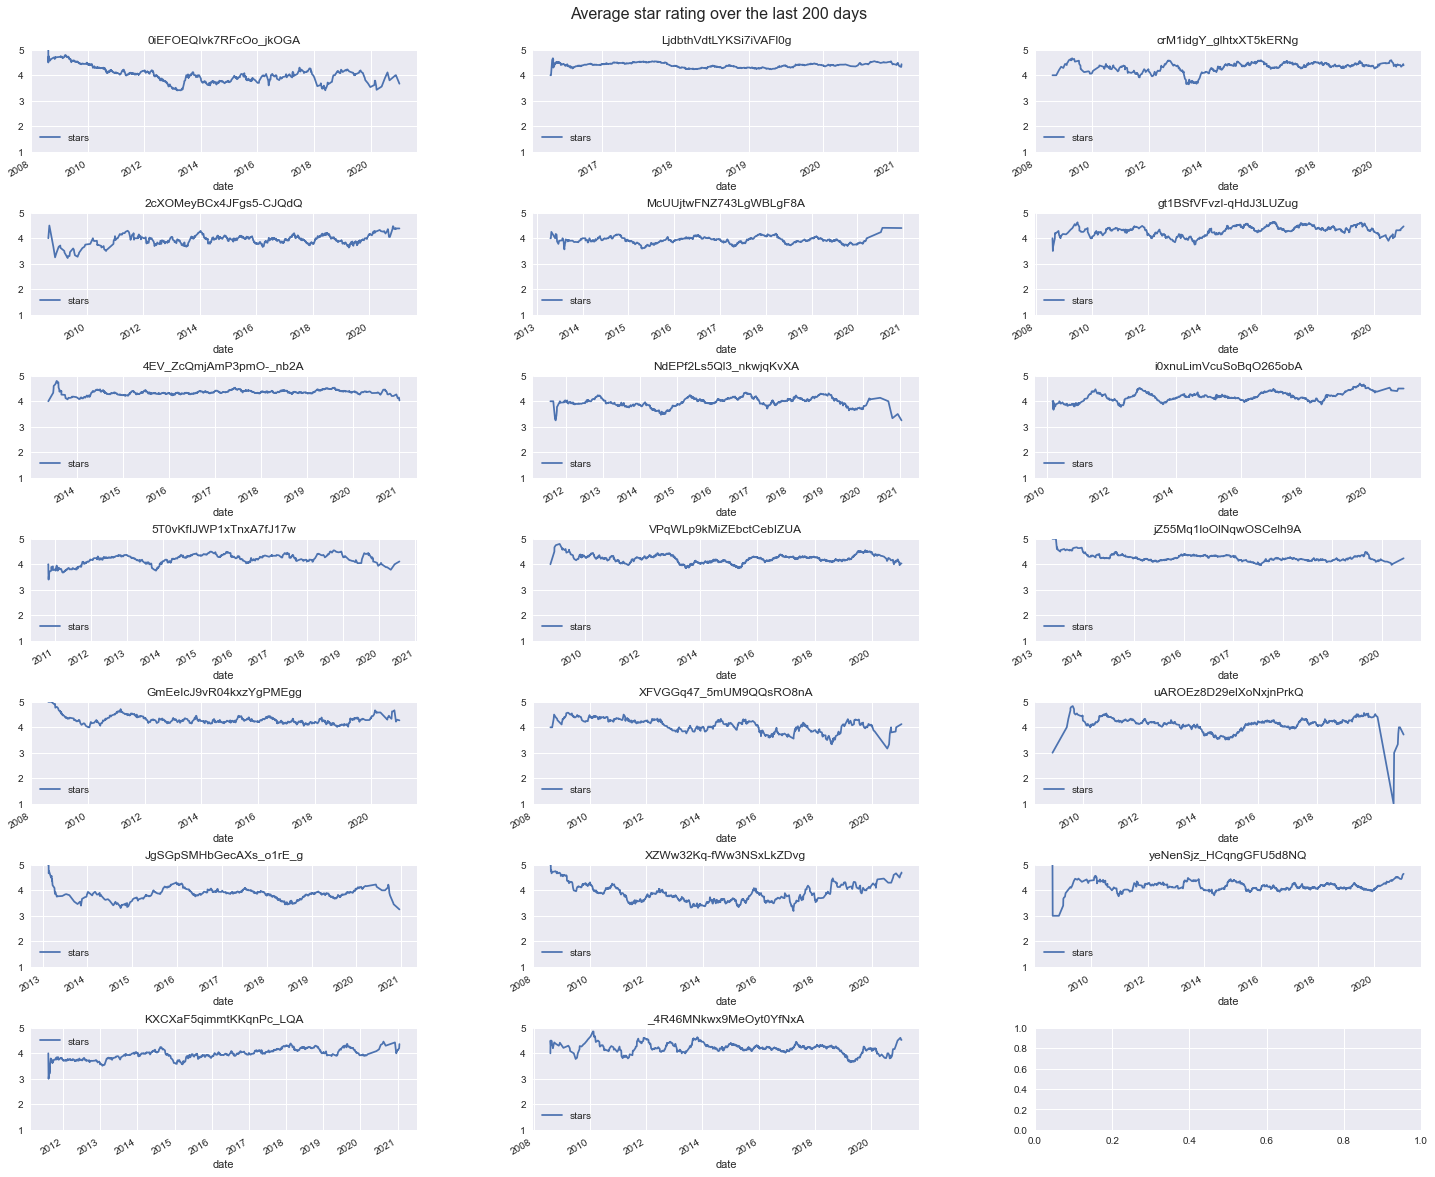

In [9]:
reviews['date'] = pd.to_datetime(reviews['date'], format='%Y-%m-%d')

mean_ratings_top_20 = reviews.loc[reviews.business_id.isin(business_ids_with_sufficient_reviews[:20]), ['business_id', 'stars', 'date']].set_index('date', inplace=False).sort_index().groupby('business_id').rolling(window='200D').agg({'stars': 'mean'})

fig, ax = plt.subplots(7,3, figsize=(20,20))
fig.tight_layout()
fig.subplots_adjust(hspace=0.6, wspace=0.3, top=0.95)
fig.suptitle('Average star rating over the last 200 days', fontsize=16)
y = 0
for i, (name, group) in enumerate(mean_ratings_top_20.groupby('business_id')):
    # calc index
    x = i % 7
    if i != 0 and x == 0:
        y += 1
    
    ax[x,y].set_ylim(1,5)
    group.reset_index().plot(x='date', y='stars', ax=ax[x,y], title=name)
    
    if i ==20:
        break

Some restaurants in this sample vary a bit, but overall they are all pretty much constantly around 4. This might be due to a bias in the users ratings. For example, if a restaurant is well known and has a very good rating, but customers are extremely unhappy, they might resort to rating it 3 stars, whilst at other places they would have rated it 1 star. The _anchor effect_ could be a potential explanation for this behavior.

Additionally, most of the times, users place reviews when they have extreme feelings about the restaurants and will vote accordingly (1 for extremely upset and 5 for extremely happy. Thus, it is unrealistic for businesses to receive constantly ratings close to 5.

However, if we are able to analyze the true sentiment of the users in their textual review, we might be able to ignore the star rating and add a secondary "__sentiment score__". In combination with topic modeling, we could potentially extract topics and assign the sentiment score to the topics. Thus, we would end up with a more granular scoring for e.g. food, service, atmosphere, etc.

With that score, we might be able to give a more realistic view onto things for the businesses, to try and find out what causes a drop in ratings and what they should be working on. We will deliver this as shown above on a rolling window of the last X days. That way, business owners are able to react more quickly to recent changes in their ratings and find out what they need to be working on.

For users, we might be able to add this as additional filters to the search for restaurants. That way users are able to filter the search results with a more realistic search.

# <a id='another_cell'>Implementation</a>
## <a id='implementation_plan'>Implementation Plan</a>
<img src='../resources/implementation_plan.jpg' />

1. Sentiment analysis with VADER. VADER was developed to perform well with texts based on social media and therefore is a great choice for the yelp dataset.
2. Topic extraction with LDA. This requires a bit of preprocessing and finetuning. We expect to end up with topics that are relevant to the restaurant business, e.g. food, service, and atmosphere
3. Topic naming with word embeddings. Usually humans have to name the topics found by LDA. However, we want to be totally crazy and use the transitive features of word embeddings and find topic names based on the top X words per topic.
4. Combining the sentiment with the topics to end up with a list of sentiments per topic.

### Choosing a representable subset
If possible, we could take the 20 most reviewed businesses. Let's see if there is anything different about them. If there is, we need to default to a random subsample in order to increase computation times.

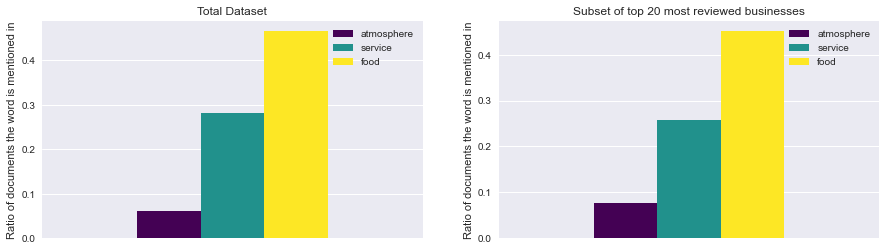

In [10]:
exemplary_occurrences = pd.DataFrame({
    'atmosphere': reviews.text.str.contains('atmosphere').mean(),
    'service': reviews.text.str.contains('service').mean(),
    'food': reviews.text.str.contains('food').mean()
}, index=['Occurences of words'])

exemplary_occurrences_subset = pd.DataFrame({
    'atmosphere': reviews.loc[reviews.business_id.isin(business_ids_with_sufficient_reviews[:20])].text.str.contains('atmosphere').mean(),
    'service': reviews.loc[reviews.business_id.isin(business_ids_with_sufficient_reviews[:20])].text.str.contains('service').mean(),
    'food': reviews.loc[reviews.business_id.isin(business_ids_with_sufficient_reviews[:20])].text.str.contains('food').mean()
}, index=['Occurences of words'])

fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].axes.get_xaxis().set_visible(False)
ax[0].set_ylabel('Ratio of documents the word is mentioned in')
ax[0].set_title('Total Dataset')
exemplary_occurrences.plot(kind='bar', ax=ax[0], colormap='viridis')

ax[1].axes.get_xaxis().set_visible(False)
ax[1].set_ylabel('Ratio of documents the word is mentioned in')
ax[1].set_title('Subset of top 20 most reviewed businesses')
exemplary_occurrences_subset.plot(kind='bar', ax=ax[1], colormap='viridis')

plt.show()

The words ratio is about the same for our subset. Let's check, if there are differences in the star ratings.

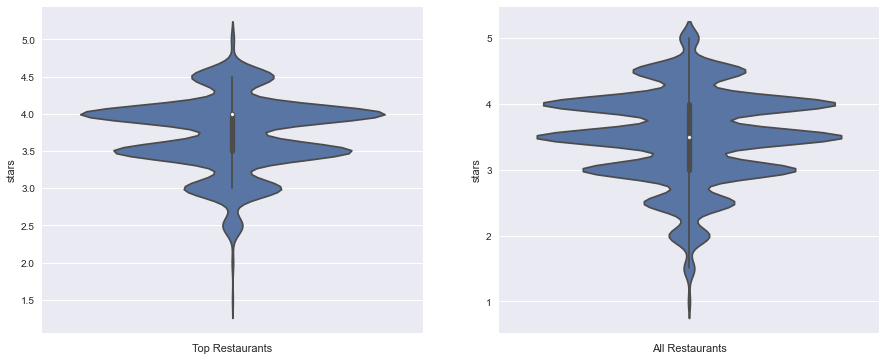

Statistics of top restaurants: µ = 3.72 +- σ 0.49
Statistics of all restaurants: µ = 3.5 +- σ 0.69


In [11]:
fig, ax = plt.subplots(1,2, figsize=(15,6))

plot_data = {'top_restaurants': restaurants.loc[restaurants.business_id.isin(business_ids_with_sufficient_reviews)].stars, 'all_restaurants': restaurants.stars}
# plot_data = [restaurants.loc[restaurants.business_id.isin(business_ids_with_sufficient_reviews)].stars, restaurants.stars]

sns.violinplot(data=plot_data, y = 'top_restaurants', ax = ax[0])
ax[0].set_xlabel('Top Restaurants')
sns.violinplot(data=plot_data, y = 'all_restaurants', ax = ax[1])
ax[1].set_xlabel('All Restaurants')
plt.show()

print(f'Statistics of top restaurants: µ = {round(plot_data["top_restaurants"].mean(),2)} +- σ {round(plot_data["top_restaurants"].std(),2)}')
print(f'Statistics of all restaurants: µ = {round(plot_data["all_restaurants"].mean(),2)} +- σ {round(plot_data["all_restaurants"].std(),2)}')

As this differs a bit too much in my opinion, I will choose a random subsample to bring computation times to a reasonable level for this task. This could easily be changed to include more reviews

In [12]:
sampled_restaurants = restaurants.business_id.sample(100, random_state=9000)
review_subsample = reviews[reviews.business_id.isin(sampled_restaurants)]
review_subsample.shape

(7909, 12)

# <a id='vader'>3.2 Sentiment analysis with VADER</a>

In [13]:
sid = SentimentIntensityAnalyzer()
# review_subsample = reviews.loc[reviews.business_id.isin(business_ids_with_sufficient_reviews[:20])]

words = set(nltk.corpus.words.words())
def remove_non_english(text):
    return " ".join(w for w in nltk.wordpunct_tokenize(text) if w.lower() in words or w.isdigit())

print(review_subsample.shape)
review_subsample = review_subsample.assign(english=review_subsample.text.map(remove_non_english))
review_subsample = review_subsample[review_subsample.english != '']
print(review_subsample.shape)

def tokenize_and_score(text, sentence_wise=True):
    tokenized_sentences = tokenize.sent_tokenize(text)
    
    if sentence_wise:
        scores = list(map(lambda x : sid.polarity_scores(x)['compound'], tokenized_sentences))
    else:
        scores = sid.polarity_scores(text)['compound']
    
    return tokenized_sentences, scores

review_subsample['tokenized'], review_subsample['scores'] = zip(*(review_subsample.text.progress_map(tokenize_and_score)))

# # TODO: should be done in one map with the scoring.
# review_subsample = review_subsample.assign(tokenized=review_subsample.text.map(lambda x: tokenize.sent_tokenize(x)))

# # vader score
# review_subsample = review_subsample.assign(score=review_subsample.text.map(lambda x : sid.polarity_scores(x)['compound']))

review_subsample[['text', 'tokenized', 'scores']].head(10)

(7909, 12)
(7903, 13)


100%|██████████| 7903/7903 [00:34<00:00, 230.70it/s]


,text,tokenized,scores
43,I had the Pad Kee Mao take-out and it was grea...,[I had the Pad Kee Mao take-out and it was gre...,"[0.6249, 0.4215]"
51,Amazing sushi. Among the best in town. I've no...,"[Amazing sushi., Among the best in town., I've...","[0.5859, 0.6369, -0.357]"
65,We visited here for my friends birthday. We ha...,"[We visited here for my friends birthday., We ...","[0.4767, 0.0, 0.5719, 0.8066, 0.3182, 0.5106]"
113,Pretty good value for the price paid but nothi...,[Pretty good value for the price paid but noth...,"[0.5789, 0.0, 0.4215]"
114,Service was excellent and the food was very go...,[Service was excellent and the food was very g...,"[0.7841, 0.7841, 0.4588]"
155,I could go on and on about this place but aint...,[I could go on and on about this place but ain...,"[0.0, 0.8481, 0.836]"
187,"Customized pasta is $8, and a glass of house w...","[Customized pasta is $8, and a glass of house ...","[0.0, 0.6696, 0.5562, 0.7783, 0.0, 0.0]"
196,We've made it a tradition to come here on Sund...,[We've made it a tradition to come here on Sun...,"[0.0, 0.0, 0.836, 0.6908, 0.4199]"
207,Korean families seem to love to celebrate fami...,[Korean families seem to love to celebrate fam...,"[0.836, 0.0, 0.4019]"
239,Really nice little hidden gem. The servers ar...,"[Really nice little hidden gem., The servers a...","[0.4754, 0.4927, 0.765]"


__Caveat:__ We should probably do it per sentence, as some sentences have separat topics. E.g. "Baristas are great. All other staff is soooo lost and vacant."

Solved

# <a id='lda'>Topic Modelling with LDA</a>
Game Plan for this step:
1. Basic preprocessing (lower case)
2. POS Tagging and filter to only nouns (relevant to topics)
3. Removal of stop words // there should not be any at this point anymore, but just to make sure
4. Stem words
5. Run LDA on the preprocessed text as a whole document.

__Caveat:__ We would like to end up with one topic per sentence. However, it has been shown that LDA struggles with short documents. Instead, we will train LDA on whole documents and will try to either apply it to sentences one by one, or average the individual probabilities per word in a sentence to get the probability of a sentence belonging to a specified topic.

For reference of the available POS tags in nltk refer to `nltk.help.upenn_tagset()`

In [14]:
#POS tagging first to utilize sentences
stemmer = SnowballStemmer('english')

def pos_tagging(row):
    list_of_preprocessed_sentences = list(filter(lambda x: x != [], [preprocess(sentence) for sentence in row]))
    return list(itertools.chain.from_iterable(list_of_preprocessed_sentences)), list_of_preprocessed_sentences 
    # return concatenated document and sentences for later

def preprocess(sentence):
    '''
    0. Convert to lower case
    1. Only allow nouns. 
    2. Remove stopwords
    3. Stem words
    '''
    pos_tag_tuples = nltk.pos_tag(nltk.word_tokenize(sentence.lower())) # lower case to avoid weird nouns
    
    nouns = []
    for pos_tag_tuple in pos_tag_tuples:
        if pos_tag_tuple[1] in [
            'NN', 'NNS', 'NNP', 'NNPS', # nouns
            'JJ', 'JJR', 'JJS', # adjectives
#             'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ' # verbs
        ]:
            # keep the word
            # but only if it is not a stop word
            if pos_tag_tuple[0] not in stopwords.words('english'):
                nouns.append(stemmer.stem(pos_tag_tuple[0]))
    
    return nouns



# review_subsample = review_subsample.assign(noun_sentences = review_subsample.tokenized.progress_map(pos_tagging))
review_subsample['prepared_documents'], review_subsample['prepared_sentences'] = zip(*review_subsample.tokenized.progress_map(pos_tagging))

# review_subsample.head(10).tokenized.progress_map(pos_tagging)

100%|██████████| 7903/7903 [05:06<00:00, 25.75it/s]


In [17]:
list_of_documents = review_subsample['prepared_documents'].to_list()

In [16]:
# 4. Remove frequent words with TF-IDF / normal frequency > 50%?
def remove_extremes(list_of_documents, removed_words: set):
    
    new_list_of_documents = []
    for sentence in list_of_documents:
        new_sentence = [w for w in sentence if w not in removed_words]
        if new_sentence != []:
            new_list_of_documents.append(new_sentence)
            
    return new_list_of_documents

In [18]:
# Create Dictionary
id2word = corpora.Dictionary(list_of_documents)
print(len(id2word))
# step 4. frequency filtering
id2word.filter_extremes(5,0.5)
print(len(id2word))

a = set(list(itertools.chain.from_iterable(list_of_documents)))
b = set(id2word.values())

# words that have been thrown out due to extreme filtering
removed_words = set(a-b)

# remove these words from the texts as well.
texts = remove_extremes(list_of_documents, removed_words)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts if id2word.doc2bow(text) != []]

14045
3699


In [20]:
joblib.dump(id2word, '../endpoint/dictionary.jbl')
joblib.dump(removed_words, '../endpoint/removed_words.jbl')

['../endpoint/removed_words.jbl']

## Coherence Calculation
Coherence measures the semantic similarity between words of one topic. There are several difference coherence measures, we chose to use C_v. One could also choose umass, which measures how often the words appear together in a corpus.

Computing 7
new best model with coherence: 0.5373876893756588
Computing 9
Computing 11
Computing 13
new best model with coherence: 0.5383275893138859
Computing 15
Computing 17


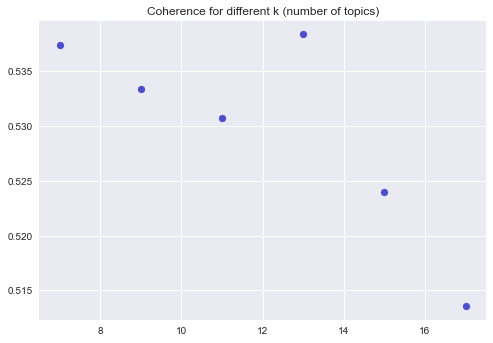

In [726]:
coherences = []
best_model = None

def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=700,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence(), lda_model


ks = range(7,18,2)
for k in ks:
    print(f'Computing {k}')
    c, m = compute_coherence_values(corpus, id2word, k, 'symmetric', 0.3)
    if best_model is None or c > max(coherences):
        best_model = m
        print(f'new best model with coherence: {c}')
    coherences.append(c)
    
ax = plt.subplot()
ax.scatter(ks, coherences, color = (0.3,0.3,0.8))
ax.set_title('Coherence for different k (number of topics)')
plt.show()

The coherence is at about 0.55 for 9 topics. This is lower than for individual sentences (0.63), but a lot less topics (121 for individual sentences).

If we include verbs into our corpus, the coherence drops to 0.50 with 11 topics.

For just nouns, 0.54 coherence with 13 topics. Now let's optimize alpha and beta.

Thus, this is a very good result for us, even though the coherence is not super high. We chose to use k=9 (should've chosen 13, but it was late, I guess) for just nouns.

# Hyperparameter Tuning

First, choose # topics according to highest coherence score for LDA model.

This is done by retraining the model with different topic numbers and seeing how the coherence develops.

> Coherence measures the relative distance between words within a topic. C_V is typically 0 < x < 1

After having chosen a good amount of topics, we can then tune the hyperparameters alpha and beta to return good-looking topics. As we train on single sentences, it is very likely that we have only one single topic per sentence. Thus, our alpha should be rather low. Additionally, we can think about making it asymmetric, to fit the distribution we have shown regarding food, service and atmosphere in a better fashion.

In [804]:
def gridsearch(alphas, betas, k):
    data = []
    best_model = None
    for a in alphas:
        for b in betas:
            coherence, model = compute_coherence_values(corpus, id2word, k, a, b)
            if best_model is None or coherence > max([d['coherence'] for d in data]):
                best_model = model
                print(f'new best model with coherence: {coherence}')
            data.append({'coherence': coherence, 'alpha': a, 'beta': b})
    return data, best_model

data, m = gridsearch(['symmetric', 'asymmetric', 0.0001, 0.01, 0.1, 0.3, 0.7, 1, 2], ['symmetric', 'auto'], 13)

new best model with coherence: 0.5162242117784932
new best model with coherence: 0.5418881836455542


In [805]:
lda_model = m

In [806]:
import pyLDAvis.gensim_models
import pickle 
import os
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('../results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
    
pyLDAvis.save_html(LDAvis_prepared, '../results/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

C:\ProgramData\Anaconda3\envs\yelp\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.010648 -0.103436       1        1  13.930530
1     -0.085784 -0.073779       2        1  13.282969
10     0.197696  0.002606       3        1  11.029141
7     -0.006024 -0.165316       4        1   8.137531
9     -0.000621  0.076540       5        1   7.886946
11     0.026317  0.064203       6        1   7.389358
3      0.065409 -0.011225       7        1   7.208042
4      0.009800 -0.017510       8        1   7.039281
5      0.119364 -0.095846       9        1   5.652465
6      0.152086  0.209018      10        1   5.415812
2     -0.029522 -0.028043      11        1   4.642652
12    -0.222609  0.012356      12        1   4.333794
8     -0.215465  0.130432      13        1   4.051479, topic_info=           Term         Freq        Total Category  logprob  loglift
1691     burger   625.000000   625.000000  Default  30.0000  30.0000
313       drink  1057.000000  1057.000000  Default  29.0000  29.0000
235       sushi   725.000000   725.000000  Default  28.0000  28.0000
75    breakfast   579.000000   579.000000  Default  27.0000  27.0000
117        cake   558.000000   558.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
44          day    50.352262   757.344825  Topic13  -4.8908   0.4953
142        time    52.134693  2621.367871  Topic13  -4.8560  -0.7115
30       servic    42.999538  2902.874834  Topic13  -5.0486  -1.0062
1532       view    39.318509   168.239839  Topic13  -5.1381   1.7524
382        area    40.166862   505.740048  Topic13  -5.1168   0.6731

[955 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
548       1  0.005509     *
548       2  0.203850     *
548       4  0.022038     *
548       5  0.005509     *
548       6  0.016528     *
...     ...       ...   ...
37        3  0.008079  yolk
37        6  0.961403  yolk
37       11  0.032316  yolk
2674      6  0.350579  zawa
2674     12  0.642728  zawa

[2642 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 11, 8, 10, 12, 4, 5, 6, 7, 3, 13, 9])

In [807]:
# store the lda model
import joblib

joblib.dump(lda_model, 'LDA_model_13.jbl')

['LDA_model_13.jbl']

Possibly replace LDA with https://github.com/adjidieng/ETM in the future. Seems promising

## <a id='combine'>3.4 Creating Topic Scores</a>

In [764]:
topic_assignments = {
    'food': [1,3,5,6,7,8,9],
    'service': [2, 4]
}

topic_assignments_reversed = {index: key for key, value in topic_assignments.items() for index in value }

My initial idea was to use word embeddings to get these clusters automatically. I wanted to achieve this, by using the transitive property of word embeddings. For example, `king + woman - man ~ queen`. If we were to do something like: `avg(words) + category - instance`, maybe we would end up with a good topic title. Unfortunately, as the topics include some very different words and sometimes the same as other topics, I am afraid this will not work as intended. 

However, I still believe that we could utilize this property, if we give it a little more thought. Maybe weighted averages? I cannot try this due to time limitations, but I would love to try this out.

In [783]:
def get_topic_scores(row):
    '''
    Calculates the scores per sentence and adds them up for a document. Ends up with score per topic.
    '''
    
    # create vars per topic dynamically
    counters = {}
    for topic in topic_assignments.keys():
        row['score_'+topic] = 0
        counters[topic] = 0

    if row.prepared_sentences == []:
        # return same score for each category
        for topic in topic_assignments.keys():
            row['score_'+topic] = np.mean(row.scores)
        return row
    
    sentences_bow = [id2word.doc2bow(text) for text in row.prepared_sentences]
    sentence_scores = list(lda_model.get_document_topics(sentences_bow))
    
    for topic_scores, vader_score in zip(sentence_scores, row.scores):
        topics, scores = zip(*topic_scores)
        
        topic = topics[np.argmax(scores)]+1 # topics here are 0 based, whilst above they are 1 based
             
        # check in which subset the key is in.
        assigned_topic = topic_assignments_reversed[topic]
        counters[assigned_topic] += 1
        row['score_'+assigned_topic] += (vader_score - row['score_'+assigned_topic]) / counters[assigned_topic]
    
    if row.shape[0] != 20:
        print(row)
    return row


review_subsample = review_subsample.progress_apply(get_topic_scores, axis=1)

100%|█████████████████████████████████████████████████████████████████████████████| 7089/7089 [00:25<00:00, 281.46it/s]


add scores together and scale from 1 - 5 for each restaurant

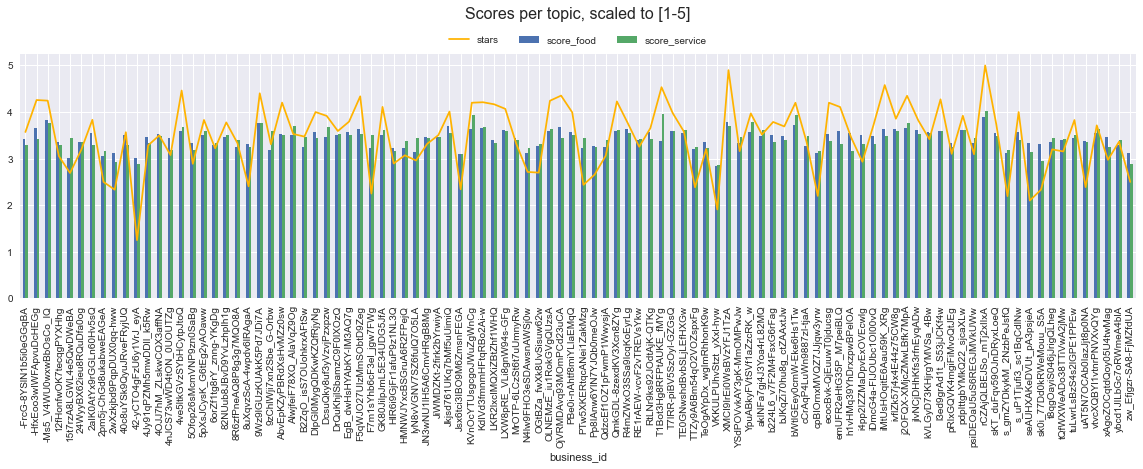

In [785]:
# get all score columns
score_cols = [ col for col in review_subsample.columns if col.startswith('score_')]

def normalize(x):
    #        (b-a)(x - min)
    # f(x) = --------------  + a
    #          max - min
    
    return (((5.0-1.0)*(np.mean(x)+1)) / (1.0 + 1.0)) + 1


aggregation_rules = {col: normalize for col in score_cols}
aggregation_rules['stars'] = 'mean'

businesses_with_ratings = review_subsample.groupby('business_id').agg(aggregation_rules)

fig, ax = plt.subplots(1,1,figsize=(20,5))

businesses_with_ratings.plot(y=score_cols, kind='bar', ax=ax)
businesses_with_ratings.plot(y=['stars'], kind='line', ax=ax, color=(1,0.7,0))

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1),
          fancybox=True, shadow=True, ncol=5)
ax.set_title('Scores per topic, scaled to [1-5]', y=1.2, pad=-14, fontsize=16)

plt.xticks(rotation=90)
plt.show()

<a id='evaluation'></a>

# 4. Evaluation
To evaluate our approach, we could do one of the following things:
1. Manual look sample-wise
2. See, if classification of stars improves when this information is used.

We will stick to (1) for now. As you can see on the top graph, our score does not fluctuate as much as the star rating. I consider this a bad thing, if the star rating is accurate. We wanted to create a more detailed rating based on the individual scores. However, utilizing the full range from 1-5 should be beneficial.

There are several explanations for this: 
1. Our approachs assigns only one topic per sentence. Reviews like the following will therefore only have one topic, whilst it should have multiple topics.
    > Great food, great service, nice atmosphere, very reasonably priced for the quality.
2. Our approach is trained on the full documents and we apply it on sentences separately. We did this to account for different topics within one document. However, this does not allow to utilize context between sentences, as each sentence is treated as its own document. One could possibly utilize the approach as outlined in this (paper)[https://pubsonline.informs.org/doi/pdf/10.1287/mnsc.2014.1930].
3. The manual assignment of clusters is not done well enough. One could think about removing a few of the less useful topics.

Another thing that shows, is that the ratings do differ a bit between food and service in our case. This was one of the goals with this approach. I expected to get more differentiation, but maybe our sample  Let us take a look at a few of the cases.

This restaurant has ca. 4 stars for service and 3.5 for food:
> "__5/5 for the service.__ The owner accidentally canceled our reservation and requested that we get drinks on the house. We truly weren't expecting anything since they were so apologetic in the first place!\n\n __4/5 for the food__. While a little pricey for mediocre empanadas and slightly dry pineapple pork, the other dishes were delicious! \n\n5/5 for the ambiance. Despite being seated in the back of the bar, the music was good, it wasn't overbearingly loud and the positive vibe from the workers made the night excellent overall!\n\nWould totally come back:)"

> "My partner and I ate at this restaurant on a recent Saturday night. We had a great experience overall! Due to Covid-19 they were open but with safety precautions in play. Great drinks and food! The food is tapa style and comes out when it is ready and in waves. We ordered the queso, pork/pineapple, corn and ceviche. All of the food was great! __The only one that we wouldn't order again is the corn, although it was flavourful it wasn't anything special. The service was great and a fun environment.__ We will be back."

There are also cases, where our rating is completely off:


In [803]:
review_subsample[review_subsample.business_id.str.startswith('42-yCT')].text[0:-1].values # T1Bot3

array(["Went here a couple of months ago, service was really nice and the sandwich i got was very good and prepared right in front of me, plus they got it on a plate to where i was sitting. Went in again today, service was okay. I waited for 10minutes, a sandwich that was wrapped up and ready suddenly appeared on the counter and they signalled to me to come get it, which I did. The sandwich was supposed to be chicken and avocado, i saw only a 1 inch piece of avocado on 1 half of the sandwich. The other half had no avocado at all. It was also barely warm and not crispy, which obviously means it was prepared ahead of time, probably for someone else who didnt end up getting it. Also  think it's a little overpriced. Don't think I'll go there again.",
       "They should have left the Costco lasagna in the nuker for a minute longer. Salad from a box is triple washed at least. Not a big fan of gallon bottle salad dressings. \nNot very engaging people and it's definitely overpriced \nI almost

Two things I realize.

1. My dataset is too biased on restaurants with good ratings (we have only the top restaurants, and they usually have high ratings, if they have so many, it means many ppl go there and therefore it must not be shabby)
2. LDA could possibly perform better, if I only train it on nouns and use VADER for sentiment regarding those nouns. Maybe then I am able to split 

In [222]:
#importing wordtovec embeddings 
from gensim.models import KeyedVectors
pretrained_embeddings_path = "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
word2vec = KeyedVectors.load_word2vec_format(pretrained_embeddings_path, binary=True)

KeyboardInterrupt: 